In [2]:
# !pip install -U sentence-transformers

In [3]:
# %pip install sentence_transformers

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import mlflow

# Loading Data

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("myrios/news-sentiment-analysis")

# print("Path to dataset files:", path)

In [ ]:
try:
    if 'dataset' not in os.listdir("../"):
        print("Dataset doesn't exist, downloading it...")
        os.makedirs('../dataset/', exist_ok=True)
        path = kagglehub.dataset_download("myrios/news-sentiment-analysis")
        print(f"Dataset original path: {path}")
        shutil.move(path, '../dataset/')
        path = "dataset/news.csv"
        print("Dataset was downloaded and put in dataset/ directory.")
    else:
        path = "../dataset/news.csv"
        print("Loading news dataset... ")
        print(f"Dataset path: {path}")
        
    
except Exception as e :
    print(f"Dataset loading error: {e}")


df = pd.read_csv(f"{path}")
df.head(5)

,date,news,neg,neu,pos,compound,sentiment
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE


# EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427482 entries, 0 to 427481
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       427482 non-null  object 
 1   news       427482 non-null  object 
 2   neg        427482 non-null  float64
 3   neu        427482 non-null  float64
 4   pos        427482 non-null  float64
 5   compound   427482 non-null  float64
 6   sentiment  427482 non-null  object 
dtypes: float64(4), object(3)
memory usage: 22.8+ MB


In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:
df.isnull().sum()

date         0
news         0
neg          0
neu          0
pos          0
compound     0
sentiment    0
dtype: int64

In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayOfTheWeek'] = df['date'].dt.dayofweek
df['hour'] = df['date'].dt.hour
df['quarter'] = df['date'].dt.quarter

In [13]:
df.describe()

,date,neg,neu,pos,compound,year,month,day,dayOfTheWeek,hour,quarter
count,427482,427482.000000,427482.000000,427482.000000,427482.000000,427482.000000,427482.000000,427482.000000,427482.000000,427482.0,427482.000000
mean,2018-06-03 08:43:42.021979648,0.140294,0.742719,0.116985,0.243870,2017.918020,6.564768,15.705192,2.728293,0.0,2.526429
min,2007-07-07 00:00:00,0.000000,0.000000,0.000000,-0.990800,2007.000000,1.000000,1.000000,0.000000,0.0,1.000000
25%,2017-01-09 00:00:00,0.000000,0.672000,0.004264,-0.340000,2017.000000,4.000000,8.000000,1.000000,0.0,2.000000
50%,2018-11-01 00:00:00,0.095000,0.782000,0.087000,0.361200,2018.000000,7.000000,16.000000,3.000000,0.0,3.000000
75%,2020-10-31 00:00:00,0.207872,0.861000,0.167336,0.877805,2020.000000,10.000000,23.000000,4.000000,0.0,4.000000
max,2024-08-03 00:00:00,1.000000,0.980000,1.000000,0.999887,2024.000000,12.000000,31.000000,6.000000,0.0,4.000000
std,NaN,0.166470,0.162196,0.135587,0.623274,3.437522,3.454782,8.788063,1.828744,0.0,1.121678


In [14]:
corr = df[['year', 'month', 'day', 'dayOfTheWeek', 'quarter', 'compound']].corr(method='pearson')
corr

,year,month,day,dayOfTheWeek,quarter,compound
year,1.000000,-0.113449,-0.004321,-0.049281,-0.111206,0.112012
month,-0.113449,1.000000,-0.015453,0.000425,0.971556,-0.000220
day,-0.004321,-0.015453,1.000000,-0.006830,-0.008403,0.002182
dayOfTheWeek,-0.049281,0.000425,-0.006830,1.000000,-0.001512,-0.003013
quarter,-0.111206,0.971556,-0.008403,-0.001512,1.000000,0.000721
compound,0.112012,-0.000220,0.002182,-0.003013,0.000721,1.000000


<Axes: >

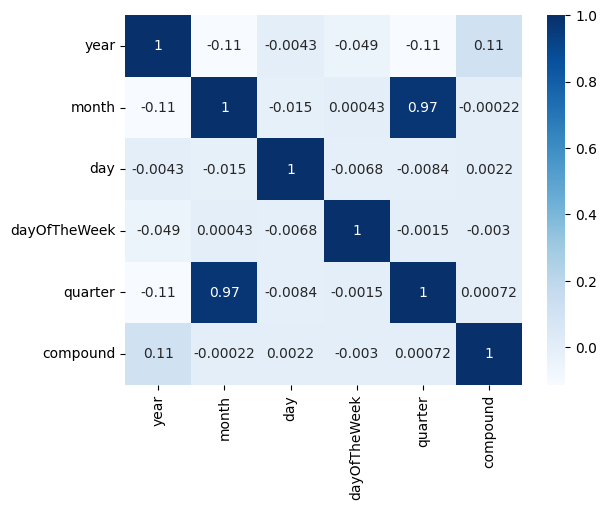

In [15]:
sns.heatmap(corr, cmap='Blues', annot=True)

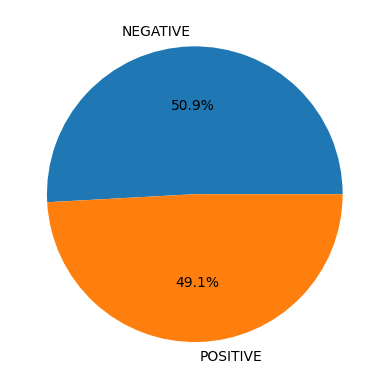

In [16]:
plt.pie(df['sentiment'].value_counts().values, labels=df['sentiment'].value_counts().index, autopct='%1.1f%%')
plt.show()

# Preprocessing

In [18]:
import re
import string

def clean_text(text):
    
    if text[0] == 'b':
        text= text[1:]
        
    if text[0] == '"' or text[0] == "'":
        text = text[1:len(text)-1]
        
    text = re.sub(r'\\+', r'\\', text)
    text = re.sub(r'(?<!\d)\\(?!\d)', '', text)

#     text = re.sub(r'^"|"$', '', text)
#     text = text.lower()
#     text = re.sub(r'\d+','', text)
#     text = text.translate(str.maketrans('', '', string.punctuation))
    
    return text

In [19]:
news = df['news'].tolist()
sentences = [clean_text(n) for n in news]
sentences

['It was a long antipodean night. While there’s no telling what’s a reflection of national taste and what’s the result of booking expediency, each of the concerts from Australia, Japan and China certainly had its own character.',
 'In Mexico there are no licensing or registration requirements for real estate agents, which means your bartender in the nightclub might show up as your agent the next day. Anyone can represent themselves as an agent. While rare, stories abound of unscrupulous or simply under-prepared agents fouling up deals. ',
 'The government has until Monday to protect the redacted names of baseball players who were supplied performance-enhancing drugs by a former Mets clubhouse attendant.',
 'A record-breaking heat wave in the Southwest is pushing northward. ',
 'England started its Live Earth concert at Wembley Stadium with an international drum tattoo: rockers at their kits, Scotsmen in kilts, Brazilian and Japanese and African drums. Then the show went decidedly Briti

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(sentences)
print(embeddings.shape)

In [86]:
# similarities = model.similarity(embeddings[21], embeddings[25])
# print(similarities)

In [87]:
encoder = OneHotEncoder(sparse_output=False, drop='if_binary').fit(df[['sentiment']])
labels = encoder.transform(df[['sentiment']])
encoder.categories_

[array(['NEGATIVE', 'POSITIVE'], dtype=object)]

In [ ]:
X = embeddings
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape)
print(X_test.shape)

In [90]:
X_eval, X_test, y_eval, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)
print(X_eval.shape)
print(X_test.shape)

In [92]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_eval = X_eval.reshape(X_eval.shape[0], X_eval.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Training Neural Network

#### Will be using LSTM since it's better than simple RNN.

In [97]:
model = tf.keras.Sequential([
    tf.keras.Input((384, 1)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Accuracy])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_loss') <= 0.15:
            print("\nModel performed good on validation data, stopping training!")
            self.model.stop_training = True

callbacks = MyCallback()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [100]:
epochs = 25
batch_size=128

model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=batch_size, \
          validation_data=(X_eval, y_eval), callbacks=[callbacks,earlystop])

Epoch 1/25
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - loss: 0.6936 - recall: 0.2060
Reached 95% Recall so cancelling training!
2505/2505 ━━━━━━━━━━━━━━━━━━━━ 1215s 484ms/step - loss: 0.6936 - recall: 0.2060 - val_loss: 0.6939 - val_recall: 1.0000


In [102]:
test_data_result = model.evaluate(X_test, y_test, verbose=1)
print("Test data Loss: ", test_data_result[0])
print("Test data Recall: ", test_data_result[1])

835/835 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step - loss: 0.6943 - recall: 1.0000
Test data Score:  0.6939685940742493
Test data Recall:  1.0


# Save model

In [120]:
models_dir = "trainedLSTMmodels/"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

dir_content = [f for f in os.listdir(models_dir) if f != '.ipynb_checkpoints']

if len(dir_content) == 0:
    model_path = f"{models_dir}/1"
    os.makedirs(model_path)
    
else:
    model_version = max([int(x) for x in dir_content]) + 1
    model_path = f"{models_dir}/{model_version}"
    os.makedirs(model_path)
    

In [122]:
# model.save(f"{model_path}//firstModelOptimizingRecall.h5", save_format="h5")
model.export(f"{model_path}//firstModelOptimizingRecall", format='tf_saved_model')

INFO:tensorflow:Assets written to: trainedLSTMmodels//1//firstModelOptimizingRecall\assets


INFO:tensorflow:Assets written to: trainedLSTMmodels//1//firstModelOptimizingRecall\assets


Saved artifact at 'trainedLSTMmodels//1//firstModelOptimizingRecall'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 384, 1), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2159239836112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159239839184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159239837264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159239838800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159239838224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159239839376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2159239839568: TensorSpec(shape=(), dtype=tf.resource, name=None)


# Load Model

In [ ]:
# # Later, in a different process / environment...
# reloaded_artifact = tf.saved_model.load("path/to/location")
# predictions = reloaded_artifact.serve(input_data)